In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/movie.csv


In [2]:
#Reading the dataset
data=pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')
data.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [3]:
#Dropping the timestamp column
new_data=data.drop(['timestamp'], axis=1)

In [4]:
new_data.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [5]:
new_data=new_data.astype('float32')

In [16]:
#Checking missing values
new_data.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

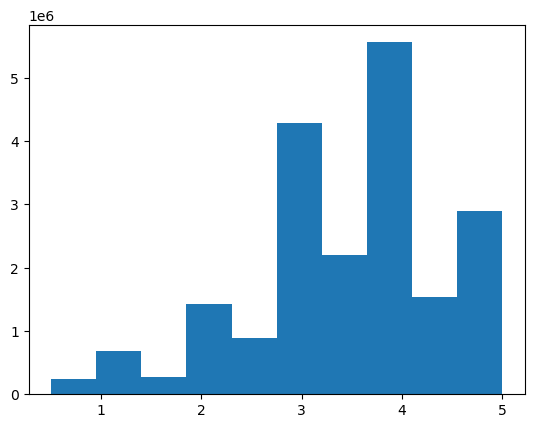

In [21]:
# Ensure plots are displayed inline in the notebook
%matplotlib inline

from matplotlib import pyplot as plt

# Create a bar plot of name vs grade
plt.hist(x=new_data['rating'])

# Display the plot
plt.show()

In [27]:
new_data.groupby(by='rating')['movieId'].count()

rating
0.5     239125
1.0     680732
1.5     279252
2.0    1430997
2.5     883398
3.0    4291193
3.5    2200156
4.0    5561926
4.5    1534824
5.0    2898660
Name: movieId, dtype: int64

<Axes: title={'center': 'movieId'}, xlabel='rating'>

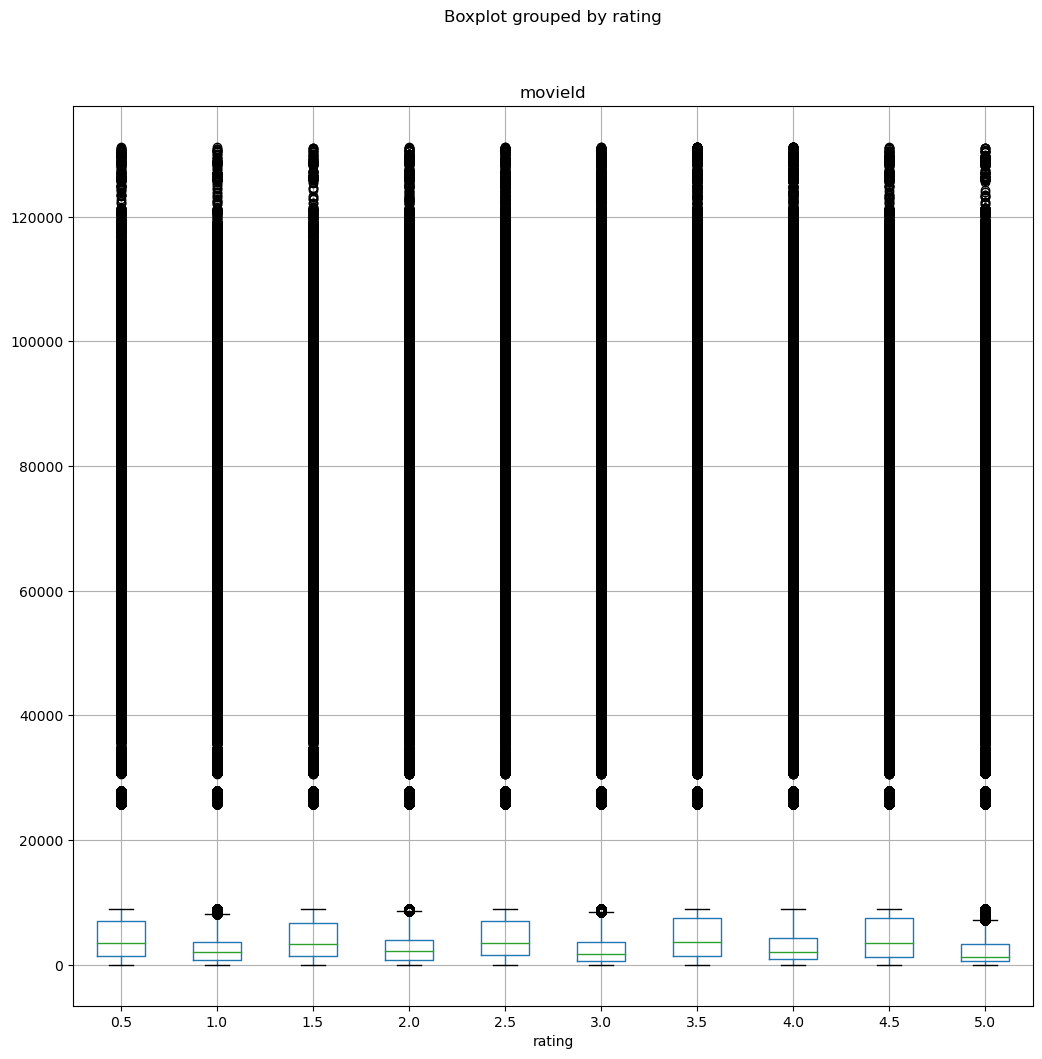

In [30]:
new_data.boxplot(column='movieId', by='rating', figsize=(12,12))

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
data['userId'] = user_encoder.fit_transform(new_data['userId'])
data['movieId'] = movie_encoder.fit_transform(new_data['movieId'])

# Split the dataset into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=new_data['rating'].values)

# Define the dataset class
class MovieDataset(Dataset):
    def __init__(self, user_ids, movie_ids, ratings):
        self.user_ids = user_ids
        self.movie_ids = movie_ids
        self.ratings = ratings
        
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        user = self.user_ids[idx]
        movie = self.movie_ids[idx]
        rating = self.ratings[idx]
        return {'user': user, 'movie': movie, 'rating': torch.tensor(rating, dtype=torch.float)}

train_dataset = MovieDataset(
    user_ids=train_data['userId'].values,
    movie_ids=train_data['movieId'].values,
    ratings=train_data['rating'].values
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the recommendation model
class Recommender(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size):
        super(Recommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, user, movie):
        user_embed = self.user_embedding(user)
        movie_embed = self.movie_embedding(movie)
        x = torch.cat([user_embed, movie_embed], dim=1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
embedding_size = 32
num_users = len(user_encoder.classes_)
num_movies = len(movie_encoder.classes_)

model = Recommender(num_users, num_movies, embedding_size)

# Check if GPUs are available and use DataParallel if so
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:  # If you have multiple GPUs
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)

model.to(device)  # Move the model to the GPU(s)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for batch in train_loader:
        users = batch['user']
        movies = batch['movie']
        ratings = batch['rating']
        
        users = users.to(device)  # Move data to the GPU(s)
        movies = movies.to(device)
        ratings = ratings.to(device)
        
        optimizer.zero_grad()
        outputs = model(users, movies).squeeze()
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
test_dataset = MovieDataset(
    user_ids=test_data['userId'].values,
    movie_ids=test_data['movieId'].values,
    ratings=test_data['rating'].values
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        users = batch['user']
        movies = batch['movie']
        ratings = batch['rating']
        
        outputs = model(users, movies).squeeze()
        loss = criterion(outputs, ratings)
        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {average_test_loss:.4f}')

Using 2 GPUs
Epoch [1/50], Loss: 0.5769


In [5]:
# Check if GPUs are available and use DataParallel if so
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:  # If you have multiple GPUs
        print(f"Using {torch.cuda.device_count()} GPUs")

Using 2 GPUs


In [ ]:
# Define the Neural Collaborative Filtering (NCF) model
class NCF(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size, hidden_layers):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.mlp_layers = nn.Sequential(
            nn.Linear(embedding_size * 2, hidden_layers[0]),
            nn.ReLU(),
            nn.Linear(hidden_layers[0], hidden_layers[1]),
            nn.ReLU(),
            nn.Linear(hidden_layers[1], 1)
        )
        
    def forward(self, user, movie):
        user_embed = self.user_embedding(user)
        movie_embed = self.movie_embedding(movie)
        x = torch.cat([user_embed, movie_embed], dim=1)
        output = self.mlp_layers(x)
        return output

# Define the Matrix Factorization model
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        
    def forward(self, user, movie):
        user_embed = self.user_embedding(user)
        movie_embed = self.movie_embedding(movie)
        output = (user_embed * movie_embed).sum(dim=1)
        return output

# Instantiate NCF and Matrix Factorization models
embedding_size = 32
hidden_layers = [64, 32]  # for NCF
num_users = len(user_encoder.classes_)
num_movies = len(movie_encoder.classes_)